In [28]:
import pandas
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
pandas.set_option('display.max_columns', 10)
pandas.set_option('display.width', 350)
    
#Get list of employee addresses
employees=pandas.read_csv("Employee_Addresses.csv")
print(employees.head())

                                          address  employee_id
0   98 Edinburgh St, San Francisco, CA 94112, USA          206
1        237 Accacia St, Daly City, CA 94014, USA         2081
2    1835 Folsom St, San Francisco, CA 94103, USA          178
3  170 Cambridge St, San Francisco, CA 94134, USA           50
4     16 Roanoke St, San Francisco, CA 94131, USA         1863


In [29]:
stops=pandas.read_csv("Bus_Stops.csv")
print(stops.head())

   Street_One         Street_Two
0  MISSION ST          ITALY AVE
1  MISSION ST  NEW MONTGOMERY ST
2  MISSION ST            01ST ST
3  MISSION ST            20TH ST
4  MISSION ST         FREMONT ST


# Q: Write an algorithm that returns the best 10 stops in your opinion. Also, please explain the rationale behind the algorithm.

### As a first step, let’s geolocate all those addresses, which is really just a fancy way to say let’s get lat and long from the addresses. In general, whenever possible, it is always a good idea to go from addresses to lat/long.


### Lat and long are continuous variables and most ML models deal very well with them, extracting tons of information. On the other hand, geographical variables stored as categorical variables (like country, state, city, address, etc) are particularly complicated for most models, especially because you typically end up having tons of different levels, each level having few events. And this is a nightmare for most ML models.

In [3]:
import geocoder
    
#We are using Bing API here, easier/faster to get an API key than google. Note that Bing tries very hard to guess a correct address even if the format is not perfect. For instance, this address below does return a specific location by guessing. Other APIs would return NAs. Both approaches (NA or guessing) are fine here and lead to comparable final results. Another approach would be cleaning the data before calling the API. For instance, removing all addresses without a non-numerical character before the first comma would take care of addresses like the one below.
print(employees.address[87])


80, San Francisco, CA 94105, USA


In [8]:
print(geocoder.bing(employees.address[87], key='AgnzdXafvb6JNDwfxlgwLwZoaZjruVVWodzFIIi7tFfwd70UeYTGL4PeemvI0F3d').latlng)

[37.78475002, -122.39318969]


In [9]:
#geolocate employee addresses 
employee_lon = []
employee_lat = []

for i in range(len(employees)):
    geocode_add = geocoder.bing(employees.address[i], key='AgnzdXafvb6JNDwfxlgwLwZoaZjruVVWodzFIIi7tFfwd70UeYTGL4PeemvI0F3d').latlng
    employee_lat.append(geocode_add[0])
    employee_lon.append(geocode_add[1])

employees_g = pandas.DataFrame({'longitude' : employee_lon,
                                'latitude' : employee_lat, 
                                })

In [10]:
geocode_add

[37.76312189, -122.41372639]

In [11]:
#Are there any NAs? Not really expecting them given how Bing Map works, but still, let's check
print(len(employees_g)==len(employees_g.dropna()))

True


In [12]:
#Geolocate bus stops:
#Fix address format so that intersections can be recognized
stops_corner = stops.Street_One + " and " +  stops.Street_Two + " san francisco, ca"

In [13]:
#geolocate stop addresses 
stops_lon = []
stops_lat = []

for i in range(len(stops_corner)):
    geocode_add = geocoder.bing(stops_corner[i], key='AgnzdXafvb6JNDwfxlgwLwZoaZjruVVWodzFIIi7tFfwd70UeYTGL4PeemvI0F3d').latlng
    stops_lat.append(geocode_add[0])
    stops_lon.append(geocode_add[1])

stops_g = pandas.DataFrame({'longitude': stops_lon, 
                            'latitude' : stops_lat, 
                                })

In [14]:
#Are there any NAs?
print(len(stops_g)==len(stops_g.dropna()))

True


In [15]:
print(stops_g.describe())

        longitude    latitude
count  119.000000  119.000000
mean  -122.412669   37.750208
std      0.067015    0.042691
min   -122.454090   37.605670
25%   -122.435430   37.723490
50%   -122.421975   37.742209
75%   -122.418699   37.774803
max   -122.019534   37.940263


# Clustering

### We have 119 bus stops and we need to choose the best 10. That means having ~1 trillion possible combinations, i.e. choose (119, 10). So let’s try to reduce the complexity of the problem by doing the following:

### Create 10 clusters based on where people live

### For each cluster, identify its cluster centroid and find the bus stop that’s closest to it

In [16]:
#Clustering: since here we have just two dimensions, both numerical, K-means should do well
from sklearn.cluster import KMeans
import geopy.distance
  
#Build k-means
employees_clusters = KMeans(n_clusters=10, init='k-means++', random_state=10)
employees_clusters.fit(employees_g)

KMeans(n_clusters=10, random_state=10)

In [17]:
employees_g['cluster'] = employees_clusters.labels_
  
#Check number of events per cluster
print(employees_g.groupby('cluster').size())

cluster
0     75
1    457
2    313
3    183
4    136
5    198
6    348
7    300
8     43
9    138
dtype: int64


In [18]:
#Looks like a few outliers (4 people) were so far that they gor their own cluster. Let's remove those people and rebuild k-means
employees_g = employees_g.loc[employees_g.cluster != np.argmin(employees_g.groupby('cluster').size().values)]
  
#Build k-means
employees_clusters.fit(employees_g)

KMeans(n_clusters=10, random_state=10)

In [19]:
employees_g['cluster'] = employees_clusters.labels_
  
#Check number of events per cluster
print(employees_g.groupby('cluster').size())

cluster
0    193
1    313
2    198
3    457
4    138
5    348
6    183
7    136
8     75
9    107
dtype: int64


In [32]:
#Store 10 Cluster centroids
cluster_centroids = pandas.DataFrame({'longitude': [x[1] for x in employees_clusters.cluster_centers_], 
                                      'latitude' : [x[0] for x in employees_clusters.cluster_centers_]
                                     })
  
#Find, for each centroid, the closest bus stop. We use geographical distance here for simplicity and to not have to call APIs. We could very well use actual walking distance by calling a map API, similarly to how we found out lat/lon from the address
best_stops = []
for i in range(10):
    centroid_tmp = (cluster_centroids['latitude'][i], cluster_centroids['longitude'][i])
    distance_from_centroid = stops_g.apply(lambda x: geopy.distance.distance(x, centroid_tmp).km,axis=1)
    best_stops.append(np.argmin(distance_from_centroid.values))

    
#Best stops are:
print(stops.loc[best_stops])

ValueError: Latitude must be in the [-90; 90] range.

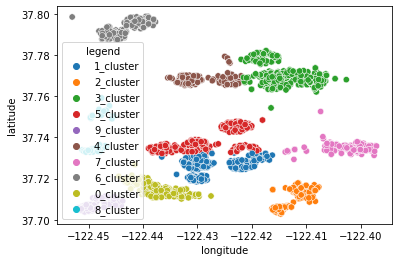

In [33]:
#Let's plot final best stops and employee addresses/clusters
#prepare dataset for plot by combining best stops and clusters
stops_g['legend'] = "Best_stop"
stops_g['point_size'] = 360
  
#rename cluster in employees_g, both the column and the actual name inside
employees_g['legend'] = employees_g.cluster.astype(str) + "_cluster"
employees_g['point_size'] = 40
del employees_g['cluster']
  
#put everything together for the plot
data_plot = pandas.concat([employees_g, stops_g.loc[best_stops]]).reset_index()
  
cluster_plot = sns.scatterplot(data=data_plot, x='longitude', y='latitude', hue='legend', s= data_plot.point_size.values)
plt.show()


### They mostly make sense, both the clusters (smaller points) and the final bus stops (those 10 larger points).



### Next Steps



### There are at least a couple of ways the outcome could be improved from a product standpoint:


### When we optimize the bus stops, we are considering all the employees. However this might not make sense. If someone is really far from their closest bus stop, they might not take the shuttle anyway. And, even if they are going to take it, it won’t make much of a difference a 25 vs a 30 minute distance. There is probably not much point in optimizing for these people. Therefore, they could be removed before doing the clustering or we could reduce their weight right before clustering.


### If two optimal bus stops end up being very close, this would be inefficient from a practical standpoint. Assume 2 bus stops are within 2 minutes from each other. It would definitely be more efficient merging those two into one stop and either just having 9 stops or adding a new one. From an algorithm standpoint, this would translate into adding a constraint when the cluster centroids are created such that their distance cannot be <X.


### A takehome challenge is rarely the place to come up with a perfect solution. After all, they are usually supposed to be solved in a few hrs max. However, adding comments about what you would do with more time is very important.


### Also, note how open ended it is. Take advantage of this by playing to your strengths. If you are great in data visualization, create informative plots. If you are a very detailed oriented person, focus on cleaning the addresses. Strong ML -> optimize the clusters. Strong product sense -> give ideas on how to improve this from a product standpoint. Engineering skills can be highlighted by using an API to get actual time that takes from each address to those stops, and so on.